<a href="https://colab.research.google.com/github/bi-horn/CNN_XRay/blob/main/CNN_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
print(torchvision.__version__)

0.16.0+cu121


In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

Defining functions

Starting with model

In [12]:
data_path = '/content/drive/My Drive/XRay/'

sample_ratio = 0.4
batch_size = 64 #smaller size to ensure better convergence
num_epochs = 20 #if computational cost would not matter, good practice would be to observe when the model does not get any better

In [13]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [36]:
#load training, test and validation datasets and preprocess the images
%run '/content/drive/My Drive/Colab Notebooks/utils.ipynb'
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

Dataset ImageFolder
    Number of datapoints: 5855
    Root location: /content/drive/My Drive/XRay/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


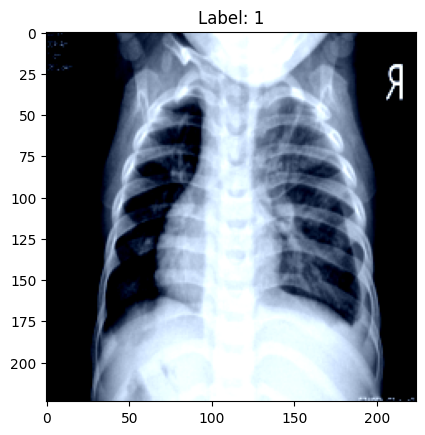

In [ ]:
#View the dataset and print a XRay image to see if everything is correctly resized and transformed

print(dataset)

#Grab 1 image
# Get one batch of data from the train loader
for images, labels in train_loader:
    break  # Exit the loop after the first batch

# Convert Tensor to numpy array
image = images[0].numpy()
label = labels[0].item()

# Denormalize the image (if normalization was applied)
# Use the inverse of the normalization transform, e.g. if you used transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# you can denormalize by multiplying by 0.5 and then adding 0.5
image = image * 0.485 + 0.229

# Display the image
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'Label: {label}')
plt.show()

In [9]:
# Define the ResNet34 model and set Pretraining to False to train model from scratch
# ResNet50 or higher is even deeper and might aim better results but it is a balance between model complexity and computational cost

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes)) #replaces the fully connected layer (model.fc) with a new one that has the output size matching the number of classes in the dataset
#print(len(dataset.classes)) #= 2 NORMAL or PNEUMONIA
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

#criterion and optimizer are inputs of the train function
model_name = "ResNet34"
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, model_name, num_epochs)

#Save pre-trained model to file
torch.save(model.state_dict(), "{}{}.pth".format(data_path, model_name))



Downloading: "https://github.com/pytorch/vision/zipball/v0.9.0" to /root/.cache/torch/hub/v0.9.0.zip
Epoch 1/20: 100%|██████████| 26/26 [00:35<00:00,  1.38s/batch, Accuracy=0.835, Loss=0.00285, Precision=0.798, Recall=0.821, F1 Score=0.807]


VALIDATION: Accuracy: 0.7532 | Loss: 1.3033 | Recall: 0.5000 | Precision: 0.3766 | F-score: 0.4296



Epoch 2/20: 100%|██████████| 26/26 [00:34<00:00,  1.34s/batch, Accuracy=0.656, Loss=0.0209, Precision=0.689, Recall=0.68, F1 Score=0.684]


VALIDATION: Accuracy: 0.7532 | Loss: 0.5434 | Recall: 0.5000 | Precision: 0.3766 | F-score: 0.4296



Epoch 3/20: 100%|██████████| 26/26 [00:33<00:00,  1.30s/batch, Accuracy=0.773, Loss=0.0081, Precision=0.699, Recall=0.677, F1 Score=0.686]


VALIDATION: Accuracy: 0.8936 | Loss: 0.2959 | Recall: 0.8366 | Precision: 0.8683 | F-score: 0.8507



Epoch 4/20: 100%|██████████| 26/26 [00:34<00:00,  1.35s/batch, Accuracy=0.855, Loss=0.0115, Precision=0.733, Recall=0.713, F1 Score=0.721]


VALIDATION: Accuracy: 0.9106 | Loss: 0.3376 | Recall: 0.9117 | Precision: 0.8690 | F-score: 0.8867



Epoch 5/20: 100%|██████████| 26/26 [00:33<00:00,  1.30s/batch, Accuracy=0.878, Loss=0.00511, Precision=0.758, Recall=0.738, F1 Score=0.747]


VALIDATION: Accuracy: 0.9234 | Loss: 0.2264 | Recall: 0.8912 | Precision: 0.9006 | F-score: 0.8958



Epoch 6/20: 100%|██████████| 26/26 [00:34<00:00,  1.32s/batch, Accuracy=0.913, Loss=0.00291, Precision=0.782, Recall=0.764, F1 Score=0.772]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1905 | Recall: 0.9257 | Precision: 0.9162 | F-score: 0.9208



Epoch 7/20: 100%|██████████| 26/26 [00:35<00:00,  1.37s/batch, Accuracy=0.927, Loss=0.0048, Precision=0.802, Recall=0.785, F1 Score=0.793]


VALIDATION: Accuracy: 0.9319 | Loss: 0.1945 | Recall: 0.9258 | Precision: 0.8994 | F-score: 0.9114



Epoch 8/20: 100%|██████████| 26/26 [00:36<00:00,  1.40s/batch, Accuracy=0.944, Loss=0.00927, Precision=0.819, Recall=0.804, F1 Score=0.811]


VALIDATION: Accuracy: 0.9234 | Loss: 0.2109 | Recall: 0.9318 | Precision: 0.8838 | F-score: 0.9034



Epoch 9/20: 100%|██████████| 26/26 [00:32<00:00,  1.23s/batch, Accuracy=0.934, Loss=0.00257, Precision=0.83, Recall=0.817, F1 Score=0.823]


VALIDATION: Accuracy: 0.9191 | Loss: 0.2252 | Recall: 0.8536 | Precision: 0.9246 | F-score: 0.8819



Epoch 10/20: 100%|██████████| 26/26 [00:32<00:00,  1.24s/batch, Accuracy=0.939, Loss=0.00274, Precision=0.841, Recall=0.827, F1 Score=0.833]


VALIDATION: Accuracy: 0.9319 | Loss: 0.2032 | Recall: 0.9432 | Precision: 0.8939 | F-score: 0.9141



Epoch 11/20: 100%|██████████| 26/26 [00:32<00:00,  1.24s/batch, Accuracy=0.953, Loss=0.0019, Precision=0.85, Recall=0.838, F1 Score=0.843]


VALIDATION: Accuracy: 0.9532 | Loss: 0.1347 | Recall: 0.9284 | Precision: 0.9442 | F-score: 0.9359



Epoch 12/20: 100%|██████████| 26/26 [00:33<00:00,  1.29s/batch, Accuracy=0.948, Loss=0.00127, Precision=0.858, Recall=0.846, F1 Score=0.851]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1381 | Recall: 0.9257 | Precision: 0.9162 | F-score: 0.9208



Epoch 13/20: 100%|██████████| 26/26 [00:33<00:00,  1.27s/batch, Accuracy=0.961, Loss=0.00277, Precision=0.865, Recall=0.854, F1 Score=0.859]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1376 | Recall: 0.9371 | Precision: 0.9274 | F-score: 0.9321



Epoch 14/20: 100%|██████████| 26/26 [00:32<00:00,  1.25s/batch, Accuracy=0.964, Loss=0.00222, Precision=0.872, Recall=0.861, F1 Score=0.866]


VALIDATION: Accuracy: 0.9532 | Loss: 0.1322 | Recall: 0.9342 | Precision: 0.9393 | F-score: 0.9367



Epoch 15/20: 100%|██████████| 26/26 [00:33<00:00,  1.31s/batch, Accuracy=0.952, Loss=0.0028, Precision=0.877, Recall=0.866, F1 Score=0.871]


VALIDATION: Accuracy: 0.9277 | Loss: 0.2379 | Recall: 0.8592 | Precision: 0.9467 | F-score: 0.8928



Epoch 16/20: 100%|██████████| 26/26 [00:33<00:00,  1.28s/batch, Accuracy=0.968, Loss=0.00182, Precision=0.882, Recall=0.872, F1 Score=0.877]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1224 | Recall: 0.9371 | Precision: 0.9274 | F-score: 0.9321



Epoch 17/20: 100%|██████████| 26/26 [00:32<00:00,  1.25s/batch, Accuracy=0.979, Loss=0.00211, Precision=0.888, Recall=0.878, F1 Score=0.883]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1289 | Recall: 0.9371 | Precision: 0.9274 | F-score: 0.9321



Epoch 18/20: 100%|██████████| 26/26 [00:32<00:00,  1.25s/batch, Accuracy=0.979, Loss=0.00109, Precision=0.893, Recall=0.883, F1 Score=0.888]


VALIDATION: Accuracy: 0.9532 | Loss: 0.1666 | Recall: 0.9457 | Precision: 0.9311 | F-score: 0.9381



Epoch 19/20: 100%|██████████| 26/26 [00:33<00:00,  1.31s/batch, Accuracy=0.97, Loss=0.00224, Precision=0.897, Recall=0.887, F1 Score=0.892]


VALIDATION: Accuracy: 0.9574 | Loss: 0.1419 | Recall: 0.9544 | Precision: 0.9349 | F-score: 0.9440



Epoch 20/20: 100%|██████████| 26/26 [00:33<00:00,  1.31s/batch, Accuracy=0.968, Loss=0.00141, Precision=0.9, Recall=0.891, F1 Score=0.895]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1419 | Recall: 0.9487 | Precision: 0.9209 | F-score: 0.9336

Training took: 12.863077024618784 minutes


In [7]:
#Version 2:
model_simple = ConvolutionalNetwork()
model_simple.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr = 0.0001)
model_name = "Simple_model"
losses, accuracies, v_accuracies, v_losses = train_model(model_simple, criterion, optimizer, model_name, num_epochs)

#Save pre-trained model to file
torch.save(model_simple.state_dict(), "{}{}.pth".format(data_path, model_name))

Epoch 1/20: 100%|██████████| 26/26 [02:50<00:00,  6.57s/batch, Accuracy=0.695, Loss=0.00883, Precision=0.501, Recall=0.5, F1 Score=0.442]


VALIDATION: Accuracy: 0.7957 | Loss: 0.4145 | Recall: 0.5862 | Precision: 0.8933 | F-score: 0.5874



Epoch 2/20: 100%|██████████| 26/26 [00:33<00:00,  1.29s/batch, Accuracy=0.882, Loss=0.00429, Precision=0.804, Recall=0.655, F1 Score=0.674]


VALIDATION: Accuracy: 0.9106 | Loss: 0.2294 | Recall: 0.8421 | Precision: 0.9108 | F-score: 0.8694



Epoch 3/20: 100%|██████████| 26/26 [00:32<00:00,  1.24s/batch, Accuracy=0.927, Loss=0.00544, Precision=0.846, Recall=0.738, F1 Score=0.766]


VALIDATION: Accuracy: 0.9191 | Loss: 0.1882 | Recall: 0.9116 | Precision: 0.8824 | F-score: 0.8954



Epoch 4/20: 100%|██████████| 26/26 [00:32<00:00,  1.27s/batch, Accuracy=0.946, Loss=0.00114, Precision=0.87, Recall=0.785, F1 Score=0.813]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1688 | Recall: 0.9055 | Precision: 0.9205 | F-score: 0.9126



Epoch 5/20: 100%|██████████| 26/26 [00:36<00:00,  1.39s/batch, Accuracy=0.952, Loss=0.00177, Precision=0.885, Recall=0.816, F1 Score=0.841]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1770 | Recall: 0.9257 | Precision: 0.9162 | F-score: 0.9208



Epoch 6/20: 100%|██████████| 26/26 [00:32<00:00,  1.26s/batch, Accuracy=0.954, Loss=0.0051, Precision=0.896, Recall=0.837, F1 Score=0.859]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1698 | Recall: 0.9199 | Precision: 0.9199 | F-score: 0.9199



Epoch 7/20: 100%|██████████| 26/26 [00:31<00:00,  1.21s/batch, Accuracy=0.962, Loss=0.00219, Precision=0.905, Recall=0.853, F1 Score=0.874]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1627 | Recall: 0.9199 | Precision: 0.9199 | F-score: 0.9199



Epoch 8/20: 100%|██████████| 26/26 [00:33<00:00,  1.28s/batch, Accuracy=0.956, Loss=0.00171, Precision=0.91, Recall=0.864, F1 Score=0.883]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1807 | Recall: 0.9459 | Precision: 0.9143 | F-score: 0.9284



Epoch 9/20: 100%|██████████| 26/26 [00:31<00:00,  1.23s/batch, Accuracy=0.951, Loss=0.00165, Precision=0.914, Recall=0.872, F1 Score=0.89]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1594 | Recall: 0.9169 | Precision: 0.9323 | F-score: 0.9243



Epoch 10/20: 100%|██████████| 26/26 [00:31<00:00,  1.22s/batch, Accuracy=0.965, Loss=0.00183, Precision=0.919, Recall=0.88, F1 Score=0.897]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1653 | Recall: 0.9169 | Precision: 0.9323 | F-score: 0.9243



Epoch 11/20: 100%|██████████| 26/26 [00:31<00:00,  1.21s/batch, Accuracy=0.971, Loss=0.00139, Precision=0.923, Recall=0.888, F1 Score=0.903]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1600 | Recall: 0.9197 | Precision: 0.9409 | F-score: 0.9297



Epoch 12/20: 100%|██████████| 26/26 [00:32<00:00,  1.26s/batch, Accuracy=0.963, Loss=0.00339, Precision=0.926, Recall=0.893, F1 Score=0.908]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1539 | Recall: 0.9169 | Precision: 0.9323 | F-score: 0.9243



Epoch 13/20: 100%|██████████| 26/26 [00:38<00:00,  1.46s/batch, Accuracy=0.966, Loss=0.00158, Precision=0.929, Recall=0.898, F1 Score=0.912]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1656 | Recall: 0.9083 | Precision: 0.9288 | F-score: 0.9179



Epoch 14/20: 100%|██████████| 26/26 [00:35<00:00,  1.37s/batch, Accuracy=0.971, Loss=0.000953, Precision=0.932, Recall=0.902, F1 Score=0.915]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1595 | Recall: 0.9285 | Precision: 0.9236 | F-score: 0.9260



Epoch 15/20: 100%|██████████| 26/26 [00:33<00:00,  1.27s/batch, Accuracy=0.974, Loss=0.000593, Precision=0.934, Recall=0.907, F1 Score=0.919]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1739 | Recall: 0.8939 | Precision: 0.9309 | F-score: 0.9104



Epoch 16/20: 100%|██████████| 26/26 [00:33<00:00,  1.27s/batch, Accuracy=0.978, Loss=0.00188, Precision=0.937, Recall=0.911, F1 Score=0.923]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1834 | Recall: 0.9517 | Precision: 0.9120 | F-score: 0.9292



Epoch 17/20: 100%|██████████| 26/26 [00:34<00:00,  1.31s/batch, Accuracy=0.968, Loss=0.00105, Precision=0.938, Recall=0.914, F1 Score=0.925]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1814 | Recall: 0.8997 | Precision: 0.9254 | F-score: 0.9115



Epoch 18/20: 100%|██████████| 26/26 [00:33<00:00,  1.30s/batch, Accuracy=0.978, Loss=0.0012, Precision=0.941, Recall=0.917, F1 Score=0.928]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1575 | Recall: 0.9313 | Precision: 0.9313 | F-score: 0.9313



Epoch 19/20: 100%|██████████| 26/26 [00:32<00:00,  1.26s/batch, Accuracy=0.975, Loss=0.00165, Precision=0.942, Recall=0.919, F1 Score=0.93]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1662 | Recall: 0.9197 | Precision: 0.9409 | F-score: 0.9297



Epoch 20/20: 100%|██████████| 26/26 [00:35<00:00,  1.37s/batch, Accuracy=0.977, Loss=0.00133, Precision=0.944, Recall=0.922, F1 Score=0.932]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1625 | Recall: 0.9169 | Precision: 0.9323 | F-score: 0.9243

Training took: 15.165270153681437 minutes


NameError: name 'model' is not defined

In [16]:
model_simple = ConvolutionalNetwork()
model_simple.to(device)
model_name = "Simple_model"
#model_simple.load_state_dict(torch.load("{}{}.pth".format(data_path, model_name)))
# Load the model onto CPU
model_simple.load_state_dict(torch.load("{}{}.pth".format(data_path, model_name), map_location=torch.device('cpu')))

<All keys matched successfully>

In [17]:
model_simple

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

 ## Load the saved model

In [34]:
model_name = "ResNet34"
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes))

model.to(device)

#model.load_state_dict(torch.load("{}{}.pth".format(data_path, model_name)))
model.load_state_dict(torch.load("{}{}.pth".format(data_path, model_name), map_location=torch.device('cpu')))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


<All keys matched successfully>

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
# Load the saved model parameters
# Assuming 'data_path' contains the path to your model
#model_path = "{}resnet18.pth".format(data_path)

def load_metrics(model_name, data_path):
  train_loss = np.load("{}{}_train_loss.npy".format(data_path, model_name))
  train_accuracy = np.load("{}{}_train_accuracy.npy".format(data_path, model_name))
  val_loss = np.load("{}{}_validation_loss.npy".format(data_path, model_name))
  val_accuracy = np.load("{}{}_validation_accuracy.npy".format(data_path, model_name))
  return train_loss, train_accuracy, val_loss, val_accuracy


losses, accuracies, v_losses, v_accuracies = load_metrics("ResNet34", data_path)
losses_sp, accuracies_sp, v_losses_sp, v_accuracies_sp = load_metrics("Simple_model", data_path)

print(losses)
print(accuracies)

print(losses_sp)
print(accuracies_sp)

[0.00284808 0.0208526  0.00809584 0.01154005 0.00511044 0.00291324
 0.00480368 0.00927368 0.00256583 0.00274083 0.0018981  0.00127239
 0.00277112 0.00222374 0.00280008 0.00181656 0.0021092  0.00109495
 0.0022359  0.00141388]
[0.83526541 0.65649786 0.77303234 0.85478951 0.87797437 0.91336181
 0.92739475 0.94447834 0.93410616 0.93898719 0.95302013 0.94752898
 0.9609518  0.96400244 0.95241001 0.96766321 0.97864552 0.97925564
 0.97010372 0.96766321]
[0.00882629 0.00428519 0.0054414  0.00113733 0.00176556 0.00510466
 0.00219382 0.00171419 0.00165087 0.00183097 0.00139441 0.00339277
 0.00158026 0.00095275 0.00059252 0.00188191 0.0010535  0.00120139
 0.00165064 0.001333  ]
[0.69493594 0.88163514 0.92678462 0.9456986  0.95179988 0.95363026
 0.96156193 0.95607077 0.95057962 0.96461257 0.97132398 0.96278218
 0.96644295 0.97071385 0.97376449 0.97803539 0.96827334 0.97803539
 0.97498475 0.97681513]


In [29]:
%run '/content/drive/My Drive/Colab Notebooks/utils.ipynb'

##Plot the Model Accuracy and Loss on Training and Validation Sets

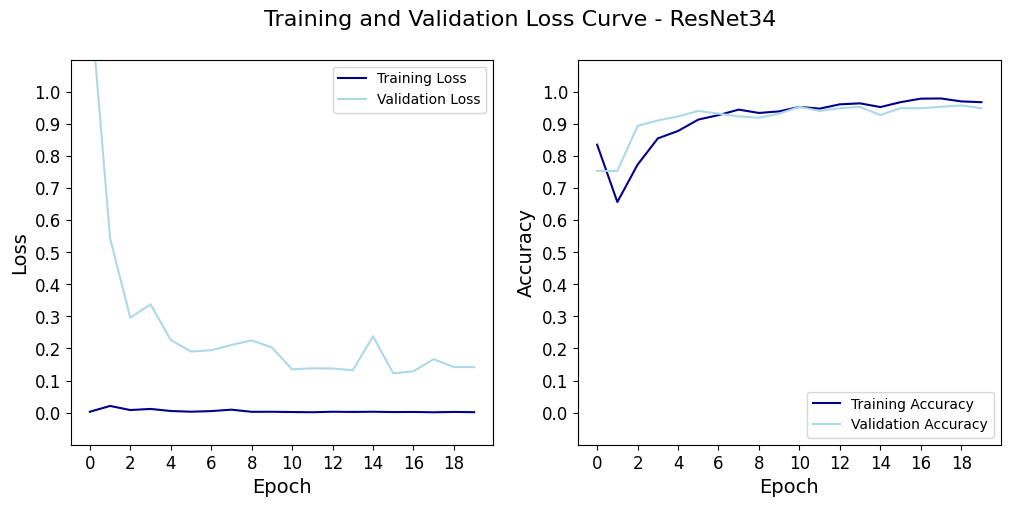

In [21]:
model_name = "ResNet34"
plot_model_curves(losses, accuracies, v_accuracies, v_losses, data_path, model_name)


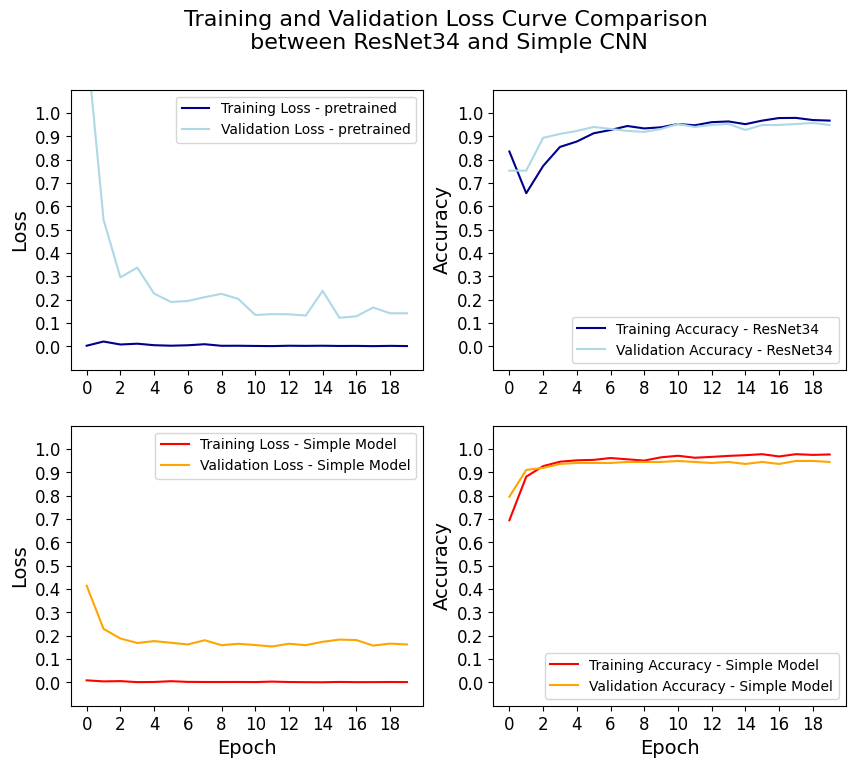

In [30]:
#surprisingly the simpler network does not perform much worse (only validation loss does not decrease as much as in ResNet34)
plot_model_curves_comp_with_simple(losses, accuracies, v_accuracies, v_losses, losses_sp, accuracies_sp, v_accuracies_sp, v_losses_sp, data_path)

##Plot the Confusion Matrix on Test Set

TEST: Accuracy: 0.9551 | Loss: 0.1324 | Recall: 0.9644 | Precision: 0.9240 | F-score: 0.9416



<Figure size 800x800 with 0 Axes>

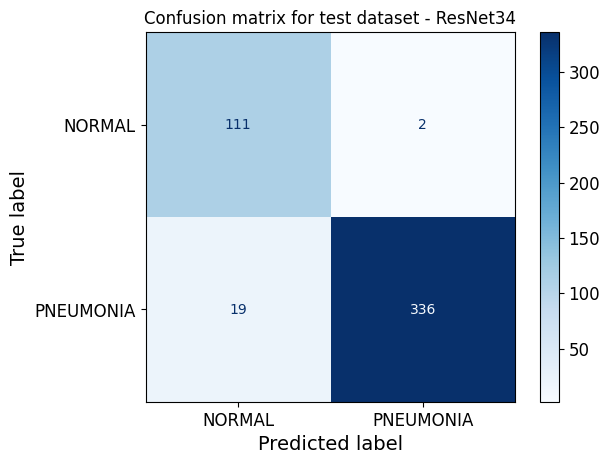

In [38]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_simple.parameters(), lr = 0.0001)

test_accuracy, test_loss, test_true, test_pred = evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "ResNet34")

plot_confusion_mat(test_true, test_pred, "ResNet34", test_loader, "test", data_path)

TEST: Accuracy: 0.9530 | Loss: 0.1389 | Recall: 0.9298 | Precision: 0.9406 | F-score: 0.9350



<Figure size 800x800 with 0 Axes>

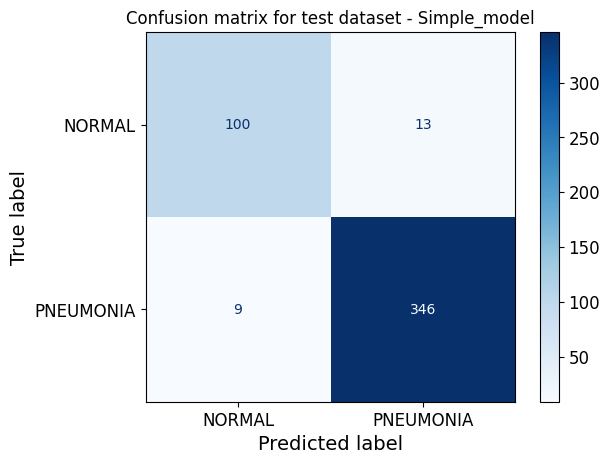

In [40]:
test_accuracy_sp, test_loss_sp, test_true_sp, test_pred_sp = evaluate_model(model_simple, test_loader, test_indices, 'TEST', criterion, data_path, "Simple_model")

plot_confusion_mat(test_true_sp, test_pred_sp, "Simple_model", test_loader, "test", data_path)

##Plot the Receiver-Operating Curve (ROC) for detecting pneumonia versus normal

##Hyperparameter tuning (here learning rate tuning)

In [ ]:

model_name = "ResNet34"
#or
#model_name = "SimpleModel"

learning_rate = [0.005, 0.0001, 0.0005, 0.00001]

for i in learning_rate:

  if model_name == "ResNet34":
        model = models.resnet34(pretrained=False)
        model.fc = nn.Linear(512, len(dataset.classes))
  elif model_name == "SimpleModel":
        model = ConvolutionalNetwork()  # Assuming ConvolutionalNetwork is defined elsewhere
  else:
        print("Error: Unknown model name")

  model.to(device)  # Assuming device is defined earlier

  print("Training Model {} with Learning Rate = {}, Batch Size = {}, Number of Epochs = {}".format(learning_rate.index(i)+1, i, batch_size, num_epochs))
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = i)

  losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, model_name, num_epochs)
  #Save Model
  torch.save(model.state_dict(), "{}{}_{}.pth". format(data_path, i, model_name))
  #Plotting the Loss and Accuracy Curves
  plot_model_curves(losses, accuracies, v_accuracies, v_losses)
  #Evaluate Model on Test Set
  evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, model_name)
